## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Step 1 

In [2]:
# Read the Excel file
file_path = "rawMeterData-123W93Street.xlsx"  # Ensure the file path is correct
xls = pd.ExcelFile(file_path)

# Read all sheets (2021-2024)
data_frames = []
for sheet_name in xls.sheet_names:
    df = xls.parse(sheet_name)  # Parse each sheet
    df['Year'] = sheet_name  # Add a Year column to indicate the sheet's year
    data_frames.append(df)

# Merge data from all years into a single DataFrame
df_all = pd.concat(data_frames, ignore_index=True)

# Check the data format
df_all.head()  # Display the first few rows of the dataset

,dateTimeStmp,raw_MM_Wh,raw_Tenant_Wh,Year
0,2021-01-01 00:00:00,9516.17,6829.72,2021
1,2021-01-01 00:15:00,8710.08,6124.53,2021
2,2021-01-01 00:30:00,8123.25,6243.97,2021
3,2021-01-01 00:45:00,8097.63,6234.43,2021
4,2021-01-01 01:00:00,9140.92,6313.70,2021


In [3]:
print(df_all.info())  # Show dataset information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131424 entries, 0 to 131423
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   dateTimeStmp   131424 non-null  object 
 1   raw_MM_Wh      131424 non-null  float64
 2   raw_Tenant_Wh  131424 non-null  float64
 3   Year           131424 non-null  object 
dtypes: float64(2), object(2)
memory usage: 4.0+ MB
None


## Step2

In [4]:
# 2.1 Count the number of zero observations in raw_MM_Wh
zero_count = (df_all['raw_MM_Wh'] == 0).sum()

print(f"Total number of zero observations in raw_MM_Wh: {zero_count}")

Total number of zero observations in raw_MM_Wh: 3615


In [5]:
# 2.2 Count the number of consecutive zero sequences
# Identify where raw_MM_Wh is zero
zero_mask = df_all['raw_MM_Wh'] == 0

# Find consecutive sequences of zeros
zero_sequences = np.diff(np.where(np.concatenate(([False], zero_mask, [False])))[0])

# Count consecutive zero streaks
zero_streaks = [length for length in zero_sequences if length > 1]

# Create a DataFrame for better analysis
df_zero_streaks = pd.DataFrame(zero_streaks, columns=['Consecutive_Zero_Count'])

print(df_zero_streaks.describe())  # Summary statistics of consecutive zero streaks

       Consecutive_Zero_Count
count              630.000000
mean               165.730159
std               1337.100433
min                  2.000000
25%                  3.000000
50%                  6.000000
75%                 16.000000
max              20516.000000


In [6]:
df_zero_streaks.head()  # Show first few streaks

,Consecutive_Zero_Count
0,4649
1,3458
2,62
3,154
4,171


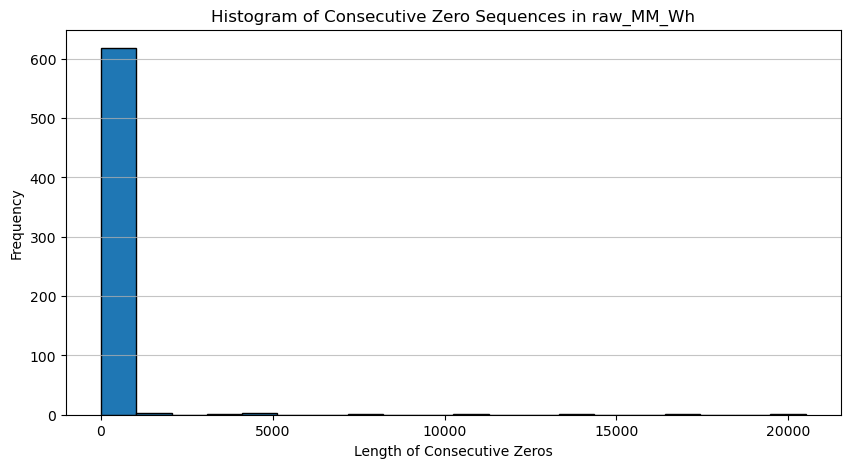

,Consecutive_Zero_Count,Frequency
0,2,143
1,3,74
2,4,61
3,7,30
4,6,29
...,...,...
101,93,1
102,100,1
103,104,1
104,109,1


In [7]:
# 2.3 Generate a histogram and tabular report of consecutive zeros
# Histogram of consecutive zero streaks
plt.figure(figsize=(10, 5))
plt.hist(df_zero_streaks['Consecutive_Zero_Count'], bins=20, edgecolor='black')
plt.xlabel("Length of Consecutive Zeros")
plt.ylabel("Frequency")
plt.title("Histogram of Consecutive Zero Sequences in raw_MM_Wh")
plt.grid(axis='y', alpha=0.75)
plt.show()

# Display tabular report
df_zero_streaks.value_counts().reset_index().rename(columns={0: 'Frequency'})

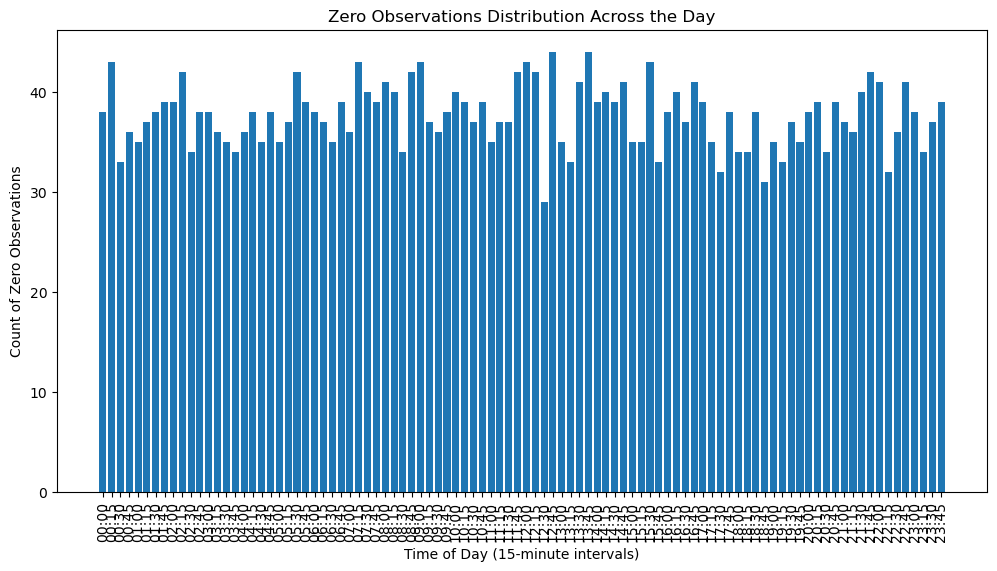

,TimeOfDay,Zero_Count
0,00:00,38
1,00:15,43
2,00:30,33
3,00:45,36
4,01:00,35
...,...,...
91,22:45,41
92,23:00,38
93,23:15,34
94,23:30,37


In [8]:
# 2.4 Analyze the time-of-day clustering of zero observations
# Convert timestamp to datetime format (if not already)
df_all['dateTimeStmp'] = pd.to_datetime(df_all['dateTimeStmp'])

# Extract time of day as hour and minute
df_all['TimeOfDay'] = df_all['dateTimeStmp'].dt.strftime('%H:%M')

# Filter out zero observations
df_zero_time = df_all[df_all['raw_MM_Wh'] == 0]

# Count occurrences per 15-minute interval
zero_time_counts = df_zero_time['TimeOfDay'].value_counts().sort_index()

# Plot histogram
plt.figure(figsize=(12, 6))
plt.bar(zero_time_counts.index, zero_time_counts.values, width=0.8)
plt.xticks(rotation=90)
plt.xlabel("Time of Day (15-minute intervals)")
plt.ylabel("Count of Zero Observations")
plt.title("Zero Observations Distribution Across the Day")
plt.show()

# Display tabular report
zero_time_counts.reset_index().rename(columns={'index': 'TimeOfDay', 'TimeOfDay': 'Zero_Count'})